# Load Python Packages

Load the required packages as follows:

In [1]:
import numpy as np
from numpy.linalg import inv, norm
from scipy.sparse.linalg import cg
from scipy.linalg import block_diag
from sklearn import metrics

# Load functions useful for COMBSS

First make sure to download the file 'combss_functions_github.py' to your current working directory. Then load all the COMBSS related functions by running the following command.

In [11]:
from combss_functions_github import *

# Generate data from a true model

Generate a ultra high-dimensional dataset as follows. It is hard to generate ultra high-dimensional data with the correlation matrix used in the paper on a regular computer. Instead, we use a block diagonal correlation matrix: Let $C$ be a correlation matrix (as decribed in the paper) of dimension $2500 \times 2500$ with correlation parameter $\rho$. Then the correlation matrix of the predictors is the block diagonal matrix given by 

\begin{equation*}
\Sigma = \begin{bmatrix}
            C & 0 & 0 & 0 \\
            0 & C & 0 & 0 \\
            0 & 0 & C & 0 \\
            0 & 0 & 0 & C
         \end{bmatrix}
\end{equation*}

### Define data parameters

In [3]:
n = 100
p = 10000
beta_type = 1
K0 = 3
beta0, model0 = gen_beta0(p, K0, beta_type)

snr = 6              
rho = 0.5 

### Generate block correlation matrix

In [4]:
p_bk = 2500
C = cov_X(p_bk, rho)
covX = block_diag(C, C, C, C)

### Generate training data

In [5]:
meanX_bk = np.zeros(p_bk)
noise_var = beta0.T@covX@beta0/snr

np.random.seed(12)

X1 = np.random.multivariate_normal(meanX_bk, C, n)
X2 = np.random.multivariate_normal(meanX_bk, C, n)
X3 = np.random.multivariate_normal(meanX_bk, C, n)
X4 = np.random.multivariate_normal(meanX_bk, C, n)

X_train = np.concatenate((X1, X2, X3, X4), axis=1)
y_train = np.array([np.random.normal(X_train[i]@beta0, noise_var) for i in range(n)])

# Generate a validation set

For tuning the penalty parameter $\lambda$, we generate a validation set similar to the training set. 

In [6]:
n_test = 5000

X1 = np.random.multivariate_normal(meanX_bk, C, n_test)
X2 = np.random.multivariate_normal(meanX_bk, C, n_test)
X3 = np.random.multivariate_normal(meanX_bk, C, n_test)
X4 = np.random.multivariate_normal(meanX_bk, C, n_test)

X_test = np.concatenate((X1, X2, X3, X4), axis = 1)
y_test = np.array([np.random.normal(X_test[i]@beta0, noise_var) for i in range(n_test)])

# Define parameters for COMBSS

Now define the parameters of COMBSS algorithm. Recall 
- $\tau$ is the paramter used to map the final $\mathbf t$ vector to a binary vector $\mathbf s$;
- $\eta$ is the parameter used for speed improvement using truncation approach; 

In [7]:
tau = 0.5
eta = 0.001

# Parameters for termination of the gradient descent
gd_tol = 0.001           # gd_tol is the tolerance of the GD method for termination.
epoch = 10               # GD terminates if the Term_cond is satisfied over epoch number of consecutive iterations.
gd_maxiter = 100000      # max number of iterations allowed by the GD method. 

# Generate a grid of $\lambda$ values

Following command generates a grid of $\lambda$ values as described in the paper.

In [8]:
lam_grid = gen_lam_grid_exp(y_train, 50, 0.8)

# Choose optimizer

ADAM optimizer is used if ADAM = True; otherwise, basic gradient descent is used. See the paper for paramters of the optimizers.

In [9]:
ADAM = True

# Run COMBSS for all the values of $\lambda$

Now we are ready to run COMBSS with the above selected optimizer. The function 'combss_mse' returns final $\mathbf t$ vector and the corresponding $\mathbf s$ vector for each $\lambda$, as well as the mean squared errors.

In [10]:
t_list, model_list, mse_arr = combss_mse(X_train, y_train, X_test, y_test, lam_grid, ADAM=ADAM, tau=tau, eta=eta, epoch=epoch, gd_maxiter=gd_maxiter, gd_tol=gd_tol)


# Summary of the results

The function 'results' summarises the results. 
- It prints optimal $\lambda$ and the corresponding model and the mse;
- It plots $\log(\lambda)$ vs mse;
- It plots $\log(\lambda)$ vs model size;
- It shows the confusion matrix;

True model: [   0 3333 6666]
Optimal lam: 0.02273598317643565
Optimal model: [   0 3333 6666] (size: 3)
Optimal MSE: 0.24823142853631003


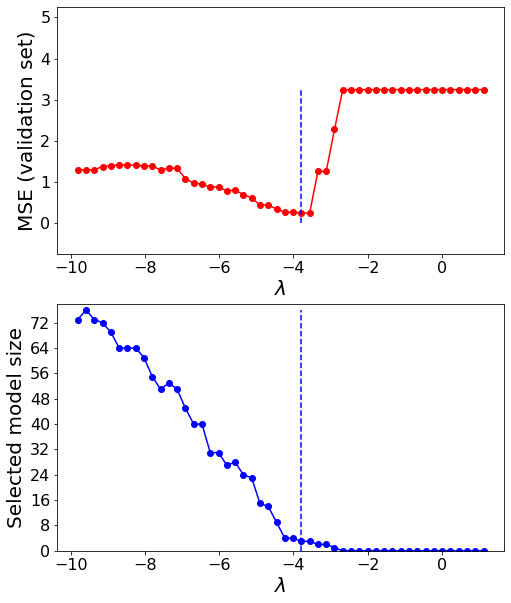

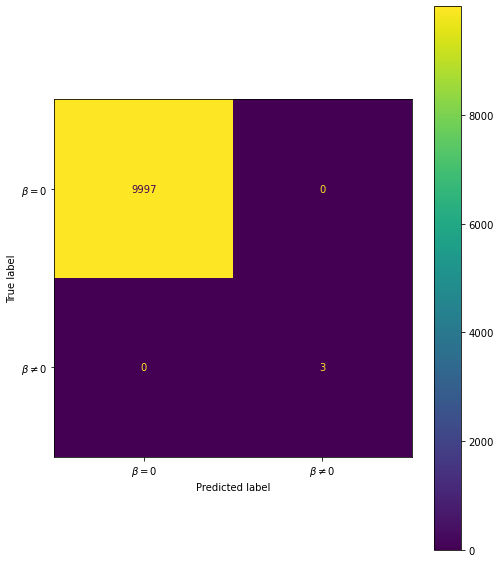

In [11]:
results(beta0, X_train, y_train, lam_grid, model_list, mse_arr)